A dataset is provided with energy readings detected in Italy with observation every 15 minutes. The question asked asks to predict the energy consumption of the day following the one analyzed.

We will create features extracted from the Consumption, to better characterize the trend. We will also introduce the weather data related to the observed period.

We will use some external libraries:
* workalendar that will provide us with the holidays in Italy
* openmeteo that will provide us with the weather data. Not having references of the consumption detection locations and knowing that they concern detections in Italy. We will apply the request by requesting the average data of Milan, Rome and Catania to have a general data.



In [3]:
# Install external libraries
#!pip install workalendar
#!pip install openmeteo-requests
#!pip install requests-cache
#!pip install retry-requests
!pip install -r requirements.txt

In addition to the libraries normally used and those already mentioned, we will use find_peaks to find the peaks related to the observations.
We will also use KNNImputer to fill the missing data in the creation of the features of the test data.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.mixture import GaussianMixture
from tensorflow import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
from workalendar.europe import Italy
import openmeteo_requests
import requests_cache
from retry_requests import retry
from scipy.signal import find_peaks

We start by loading the dataset that reports the consumption readings at the quarter of an hour and therefore each day will be composed of 96 readings.


In [ ]:
df = pd.read_csv('dataset/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420765 entries, 0 to 420764
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  420765 non-null  int64  
 1   Datetime    420765 non-null  object 
 2   Consumo     420765 non-null  float64
 3   Cons+96     420765 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 12.8+ MB


We immediately notice that the dataset starts with the first detection at 01:00, therefore the first day is not complete (the first 4 detections are missing).

Since we will use additional features related to the single day, we will eliminate the first 92 rows of the dataset.

We also note that we have 420765 rows of data.
Doing a quick count to see how many days we have in the dataset (420765-92)/96 = 4382.010417 we notice that we do not have an integer, therefore we go to check the entire dataset and we find that on the date 03/31/2023 at 23:00 there are 2 detections.

We will exclude one to bring the day back to compatibility.

In [ ]:
print (df[df['Datetime'].duplicated()])

df[(df['Datetime'] >= "2023-03-31 22:30:00") & (df['Datetime'] <= "2023-03-31 23:30:00")]

        Unnamed: 0             Datetime       Consumo       Cons+96
394361      394361  2023-03-31 23:00:00  34402.514694  3.456118e+06


,Unnamed: 0,Datetime,Consumo,Cons+96
394358,394358,2023-03-31 22:30:00,35413.373135,3.464540e+06
394359,394359,2023-03-31 22:45:00,34828.568250,3.461907e+06
394360,394360,2023-03-31 23:00:00,34510.821540,3.459179e+06
394361,394361,2023-03-31 23:00:00,34402.514694,3.456118e+06
394362,394362,2023-03-31 23:15:00,34157.397490,3.452833e+06
394363,394363,2023-03-31 23:30:00,33717.707260,3.449491e+06


In [ ]:
# Number of observations to analyze
seq_length = 96

In [ ]:
# Make a copy the last 10 days of dataset to use later when we build features on the test data.
df_pad_test = df.iloc[-(seq_length*10):, :].copy()

In [ ]:
# Add the last test rows to the train dataset to create the add_features.
# This is necessary because we are going to calculate the moving average and the moving standard deviation.
df_last = pd.read_csv('dataset/test.csv')
df_last['Cons+96'] = 0.
df_padded = pd.concat([df,df_last[:seq_length]])
df_padded

,Unnamed: 0,Datetime,Consumo,Cons+96
0,0,2012-01-01 01:00:00,32948.796139,3.221301e+06
1,1,2012-01-01 01:15:00,32539.028126,3.218459e+06
2,2,2012-01-01 01:30:00,32124.079359,3.215472e+06
3,3,2012-01-01 01:45:00,31703.946156,3.212443e+06
4,4,2012-01-01 02:00:00,31278.624678,3.209437e+06
...,...,...,...,...
91,420856,2024-01-01 22:45:00,29323.133107,0.000000e+00
92,420857,2024-01-01 23:00:00,28747.934749,0.000000e+00
93,420858,2024-01-01 23:15:00,28255.392829,0.000000e+00
94,420859,2024-01-01 23:30:00,27845.561992,0.000000e+00


In [ ]:
# We only take the rows starting from the first full day and eliminate the duplicate data
df_fixed= df_padded[df_padded['Datetime'] >= "2012-01-02 00:00:00"]
df_fixed = df_fixed.drop_duplicates(subset=['Datetime'])
df_fixed

,Unnamed: 0,Datetime,Consumo,Cons+96
92,92,2012-01-02 00:00:00,34124.900628,4.054569e+06
93,93,2012-01-02 00:15:00,33193.945635,4.057742e+06
94,94,2012-01-02 00:30:00,32193.399650,4.060854e+06
95,95,2012-01-02 00:45:00,31225.759710,4.063943e+06
96,96,2012-01-02 01:00:00,30393.681086,4.066999e+06
...,...,...,...,...
91,420856,2024-01-01 22:45:00,29323.133107,0.000000e+00
92,420857,2024-01-01 23:00:00,28747.934749,0.000000e+00
93,420858,2024-01-01 23:15:00,28255.392829,0.000000e+00
94,420859,2024-01-01 23:30:00,27845.561992,0.000000e+00


Analyzing Consumption on its temporal distribution, we see that we have a non-normal distribution.

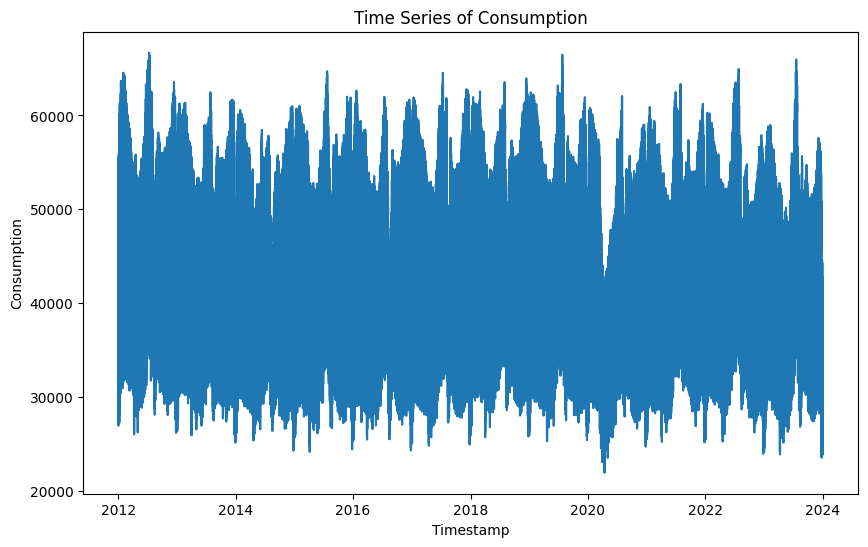

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df_fixed['Datetime']), df_fixed['Consumo'])
plt.xlabel('Timestamp')
plt.ylabel('Consumption')
plt.title('Time Series of Consumption')
plt.show()

I check the trend of Consumption by tracing a Gaussian through the function provided by GaussianMixture.

From the distribution we can see how there is a recurring form which is therefore linked to seasonality.

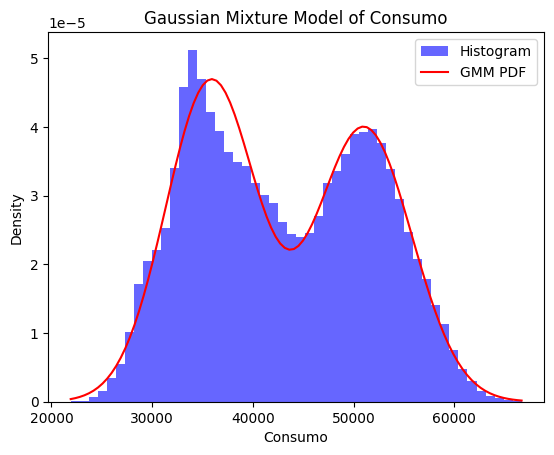

In [ ]:
# Get the 'Consumo' column from df_train
data = df_fixed['Consumo'].values.reshape(-1, 1)

# Fit a Gaussian Mixture Model with 2 components
n_components = 2
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Create the histogram
plt.hist(data, bins=50, density=True, alpha=0.6, color='b', label='Histogram')

# Evaluate GMM PDF over a range of values
x = np.linspace(data.min(), data.max(), 100).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

# Plot the PDF
plt.plot(x, pdf, 'r', label='GMM PDF')
plt.xlabel('Consumo')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model of Consumo')
plt.legend()
plt.show()

Creating the necessary features that will help our model train correctly.
* moving average based on the 96 subsequent observations: It helps us identify periods of high and low volatility in a time series.
* moving standard deviation based on the 96 subsequent observations
* consumption of the previous day relative to the same time slot.
* identify the days relative to the season they belong to, in order to have information for the hottest months.
* flag working days, as a difference in consumption is assumed between these and holidays.
* insert the day of the week as an additional characteristic of the day.
* Weather data: temperatures, cloudiness, solar irradiation. We use this data because it is assumed that they are highly correlated with energy production.
* Peak relationship: We will identify consumption peaks to help the model follow the trend.

We will use the add_knninput function only for the test data to add an additional 96 rows where we expect the next Consumption data, to calculate mean and std_dev.

the score_peaks function is used to identify the consumption peaks which will then be added together to create the rel_pecchi column.

In [ ]:
# Weather data upload function
def get_weather_data(params):
  # Setup the Open-Meteo API client with cache and retry on error
  cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
  retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
  openmeteo = openmeteo_requests.Client(session = retry_session)

  url = "https://archive-api.open-meteo.com/v1/archive"
  responses = openmeteo.weather_api(url, params=params)

  dizionari = []

  # Process first location. Add a for-loop for multiple locations or weather models
  for response in responses:

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
    hourly_terrestrial_radiation = hourly.Variables(2).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
      start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
      end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
      freq = pd.Timedelta(seconds = hourly.Interval()),
      inclusive = "left"
    ).strftime('%Y-%m-%d %H:%M:%S')}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["cloud_cover"] = hourly_cloud_cover
    hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation

    dizionari.append(hourly_data)

  risultato = {"date": dizionari[0]["date"]}
  for chiave in ["temperature_2m", "cloud_cover", "terrestrial_radiation"]:
    risultato[chiave] = sum(d[chiave] for d in dizionari) / 3

  df_meteo = pd.DataFrame(data = hourly_data)
  #df_meteo.to_csv("dataset/meteo.csv")

  return df_meteo

def add_knninput(df, day_observation):
  df_imputed = df.copy()

  # Start date
  data_partenza = pd.to_datetime(df['Datetime'].iloc[-1]) + pd.Timedelta(minutes=15)

  # Add 96 rows to the copied Dataset, initially with missing values ​​for the Consumption column
  for _ in range(day_observation):
    nuova_riga = pd.DataFrame({'Datetime': [data_partenza]})
    df_imputed = pd.concat([df_imputed, nuova_riga], ignore_index=True)
    data_partenza += pd.Timedelta(minutes=15)

  # Create a KNNImputer and adapt it to the original data in the Consumption column
  imputer = KNNImputer(n_neighbors=5)
  imputer.fit(df[['Consumo']])

  # Transform the data by imputing missing values ​​in the Consumption column of the copied DataFrame
  df_imputed['Consumo'] = imputer.transform(df_imputed[['Consumo']])

  return df_imputed

def score_peaks(data):
  # Calculate the average of the data
  mean = np.mean(data)

  # Trova i picchi positivi e negativi
  peaks_pos, _ = find_peaks(data)
  peaks_neg, _ = find_peaks(-data)

  # Find the positive and negative peaks
  distances_pos = data[peaks_pos] - mean
  distances_neg = -data[peaks_neg] - mean

  # Normalize the distances in the range -1 +1 and concatenate
  max_distance_pos = np.max(distances_pos)
  scores_pos = (distances_pos / max_distance_pos) * 1

  max_distance_neg = np.max(distances_neg)
  scores_neg = (distances_neg / max_distance_neg) * -1

  peaks = np.concatenate((peaks_pos, peaks_neg))
  scores = np.concatenate((scores_pos, scores_neg))

  return peaks, scores

def add_features(df, day_observation, typetrain = True):
  # only for test data
  if typetrain == False:
    df = add_knninput(df, day_observation)

  media, dev_std = [], []
  for i in range(len(df) - day_observation):
    media.append(df["Consumo"][i+1 : i+1+day_observation].mean())
    dev_std.append(df["Consumo"][i+1 : i+1+day_observation].std())

  media.extend(np.zeros(shape=(day_observation,)))
  dev_std.extend(np.zeros(shape=(day_observation,)))

  df["media_mobile"] = media
  df["dev_std"] = dev_std

  # logarithmic transformation of Consumption
  df['log_consumo'] = np.log(df['Consumo'])

  # representation of the previous day's consumption
  df['consumo_gg_prec'] = df['Consumo'].shift(day_observation)

  # Creation of the seasons dictionary 1-spring, 2-summer, 3-autumn, 4-winter
  stagioni = {
      3: 1, 4: 1, 5: 1,
      6: 2, 7: 2, 8: 2,
      9: 3, 10: 3, 11: 3,
      12: 4, 1: 4, 2: 4
  }
  # add season indicator
  df.loc[:, 'season'] = pd.to_datetime(df['Datetime']).dt.month.map(stagioni)

  # we identify holidays with the help of the workalendar library
  cal = Italy()
  df.loc[:, 'workday'] = pd.to_datetime(df['Datetime']).apply(cal.is_working_day).astype(int)

  # we insert the day of the week
  df['weekday'] = pd.to_datetime(df['Datetime']).dt.weekday

  # we insert weather data into the dataframe
  meteo_params = {
    "latitude": [45.5921, 41.8919, 37.4922],
    "longitude": [9.5734, 12.5113, 15.0704],
    "start_date": (pd.to_datetime(df['Datetime'].iloc[0]) - pd.DateOffset(days=1)).strftime('%Y-%m-%d'),
    "end_date": pd.to_datetime(df['Datetime'].iloc[-1]).strftime('%Y-%m-%d'),
    "hourly": ["temperature_2m", "cloud_cover", "terrestrial_radiation"],
    "timezone": "Europe/Berlin"
	}
  df_meteo = get_weather_data(meteo_params)
  df_tot = pd.merge(df, df_meteo, left_on='Datetime', right_on='date', how='left')
  df_tot = df_tot.drop('date', axis=1)
  df_tot = df_tot.ffill()
  df = df_tot.copy()

  # Calculate peak scores
  df['picchi'] = 1e-012
  peaks, scores = score_peaks(df['Consumo'])
  df.loc[peaks, 'picchi'] = scores
  df['rel_picchi'] = (df['Consumo'] * 0.1) + df['picchi']
  df = df.drop('picchi', axis=1)

  # Cons+96 move to end of dataset
  df.insert(len(df.columns) - 1, 'Cons+96', df.pop('Cons+96'))

  # return df without padded data
  df = df[:-day_observation]

  return df


In [ ]:
df_train = add_features(df_fixed, seq_length)
df_train

,Unnamed: 0,Datetime,Consumo,media_mobile,dev_std,log_consumo,consumo_gg_prec,season,workday,weekday,temperature_2m,cloud_cover,terrestrial_radiation,rel_picchi,Cons+96
0,92,2012-01-02 00:00:00,34124.900628,42235.094978,9343.074963,10.437783,NaN,4,1,0,7.4485,0.0,0.0,3412.490063,4.054569e+06
1,93,2012-01-02 00:15:00,33193.945635,42268.150348,9316.326318,10.410123,NaN,4,1,0,7.4485,0.0,0.0,3319.394563,4.057742e+06
2,94,2012-01-02 00:30:00,32193.399650,42300.561367,9286.271659,10.379517,NaN,4,1,0,7.4485,0.0,0.0,3219.339965,4.060854e+06
3,95,2012-01-02 00:45:00,31225.759710,42332.740956,9252.782495,10.348999,NaN,4,1,0,7.4485,0.0,0.0,3122.575971,4.063943e+06
4,96,2012-01-02 01:00:00,30393.681086,42364.575256,9216.459610,10.321990,NaN,4,1,0,7.3485,0.9,0.0,3039.368109,4.066999e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420667,420760,2023-12-31 22:45:00,29727.952578,29884.328742,3746.946547,10.299843,30084.518970,4,0,6,11.0050,6.3,0.0,2972.795258,2.868896e+06
420668,420761,2023-12-31 23:00:00,29234.561949,29879.259708,3748.163800,10.283107,29527.428867,4,0,6,10.5550,14.4,0.0,2923.456195,2.868409e+06
420669,420762,2023-12-31 23:15:00,28826.199969,29873.313801,3750.304048,10.269040,29035.546394,4,0,6,10.5550,14.4,0.0,2882.619997,2.867838e+06
420670,420763,2023-12-31 23:30:00,28502.912864,29866.466396,3753.431301,10.257762,28608.912735,4,0,6,10.5550,14.4,0.0,2850.291286,2.867181e+06


In [ ]:
# Eliminate the NaN data relative to the first day of the dataset from which the calculations were performed
df_train = df_train[df_train['Datetime'] >= "2012-01-03 00:00:00"]
df_train

,Unnamed: 0,Datetime,Consumo,media_mobile,dev_std,log_consumo,consumo_gg_prec,season,workday,weekday,temperature_2m,cloud_cover,terrestrial_radiation,rel_picchi,Cons+96
96,188,2012-01-03 00:00:00,37450.200276,43873.230185,8755.043970,10.530767,34124.900628,4,1,1,9.2485,69.299995,0.0,3745.020028,4.211830e+06
97,189,2012-01-03 00:15:00,36367.261113,43875.098283,8753.444520,10.501424,33193.945635,4,1,1,9.2485,69.299995,0.0,3636.726111,4.212009e+06
98,190,2012-01-03 00:30:00,35304.857534,43876.644223,8751.927976,10.471776,32193.399650,4,1,1,9.2485,69.299995,0.0,3530.485753,4.212158e+06
99,191,2012-01-03 00:45:00,34315.000181,43877.952911,8750.492437,10.443338,31225.759710,4,1,1,9.2485,69.299995,0.0,3431.500018,4.212283e+06
100,192,2012-01-03 01:00:00,33449.773939,43879.118703,8749.095852,10.417800,30393.681086,4,1,1,9.3985,79.199997,0.0,3344.977394,4.212395e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420667,420760,2023-12-31 22:45:00,29727.952578,29884.328742,3746.946547,10.299843,30084.518970,4,0,6,11.0050,6.300000,0.0,2972.795258,2.868896e+06
420668,420761,2023-12-31 23:00:00,29234.561949,29879.259708,3748.163800,10.283107,29527.428867,4,0,6,10.5550,14.400000,0.0,2923.456195,2.868409e+06
420669,420762,2023-12-31 23:15:00,28826.199969,29873.313801,3750.304048,10.269040,29035.546394,4,0,6,10.5550,14.400000,0.0,2882.619997,2.867838e+06
420670,420763,2023-12-31 23:30:00,28502.912864,29866.466396,3753.431301,10.257762,28608.912735,4,0,6,10.5550,14.400000,0.0,2850.291286,2.867181e+06


In [ ]:
#see train info.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420576 entries, 96 to 420671
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             420576 non-null  int64  
 1   Datetime               420576 non-null  object 
 2   Consumo                420576 non-null  float64
 3   media_mobile           420576 non-null  float64
 4   dev_std                420576 non-null  float64
 5   log_consumo            420576 non-null  float64
 6   consumo_gg_prec        420576 non-null  float64
 7   season                 420576 non-null  int64  
 8   workday                420576 non-null  int64  
 9   weekday                420576 non-null  int32  
 10  temperature_2m         420576 non-null  float32
 11  cloud_cover            420576 non-null  float32
 12  terrestrial_radiation  420576 non-null  float32
 13  rel_picchi             420576 non-null  float64
 14  Cons+96                420576 non-null  

In [ ]:
# Use a StandardScaler
scaler = StandardScaler()

# Select the name columns
columns = df_train.columns[2:]
print(columns)

# Fit and transform the selected numerical columns
df_encoded = scaler.fit_transform(df_train[columns])

df_encoded_plt = pd.DataFrame(df_encoded, columns=columns)

Index(['Consumo', 'media_mobile', 'dev_std', 'log_consumo', 'consumo_gg_prec',
       'season', 'workday', 'weekday', 'temperature_2m', 'cloud_cover',
       'terrestrial_radiation', 'rel_picchi', 'Cons+96'],
      dtype='object')


You can see how the moving average follows our target perfectly, while the moving standard deviation has a very similar distribution.

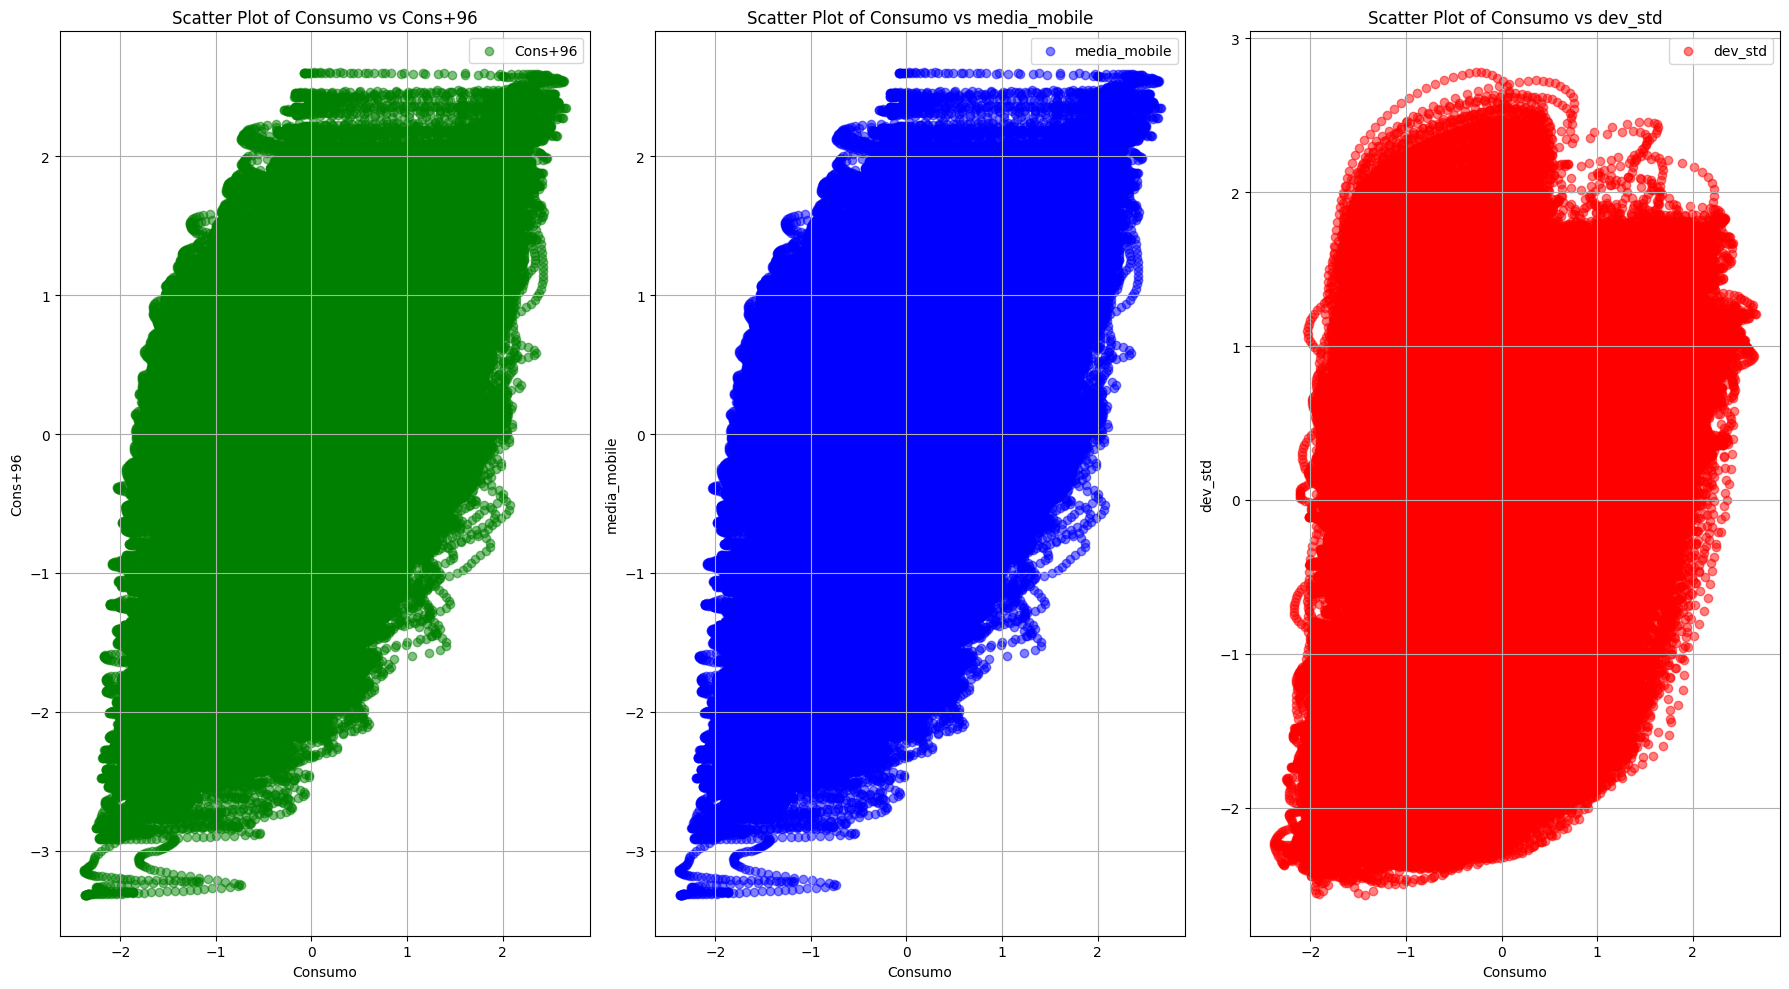

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Subplot 1: Consumo vs Cons+96
axes[0].scatter(df_encoded_plt['Consumo'], df_encoded_plt['Cons+96'], color='green', label='Cons+96', alpha=0.5)
axes[0].set_xlabel('Consumo')
axes[0].set_ylabel('Cons+96')
axes[0].set_title('Scatter Plot of Consumo vs Cons+96')
axes[0].legend(loc="best")
axes[0].grid(True)

# Subplot 2: Consumo vs media_mobile
axes[1].scatter(df_encoded_plt['Consumo'], df_encoded_plt['media_mobile'], color='blue', label='media_mobile', alpha=0.5)
axes[1].set_xlabel('Consumo')
axes[1].set_ylabel('media_mobile')
axes[1].set_title('Scatter Plot of Consumo vs media_mobile')
axes[1].legend(loc="best")
axes[1].grid(True)

# Subplot 3: Consumo vs dev_std
axes[2].scatter(df_encoded_plt['Consumo'], df_encoded_plt['dev_std'], color='red', label='dev_std', alpha=0.5)
axes[2].set_xlabel('Consumo')
axes[2].set_ylabel('dev_std')
axes[2].set_title('Scatter Plot of Consumo vs dev_std')
axes[2].legend(loc="best")
axes[2].grid(True)

plt.tight_layout()
plt.show()

The histogram of the logarithmic Consumption shows us how to represent the trend of Consumption well.

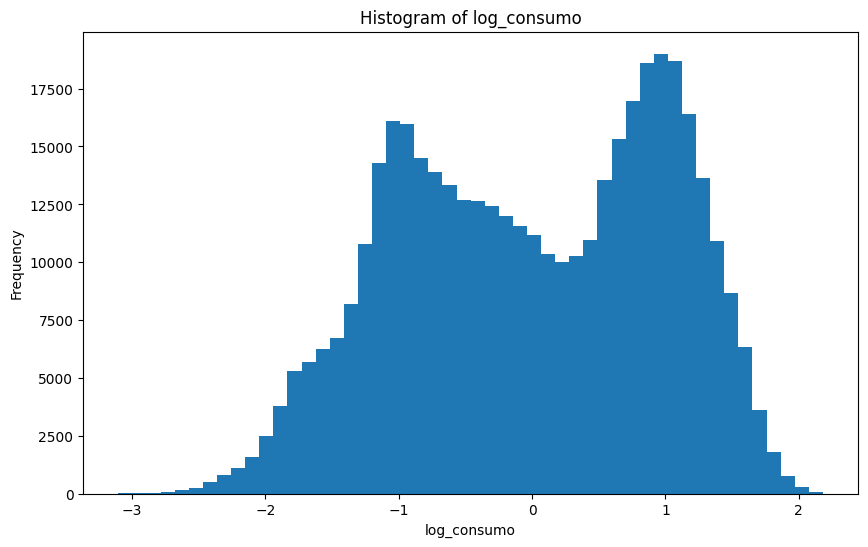

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_encoded_plt['log_consumo'], bins=50)
plt.xlabel('log_consumo')
plt.ylabel('Frequency')
plt.title('Histogram of log_consumo')
plt.show()

This visualization shows us that there is a correlation between consumption patterns on consecutive days.

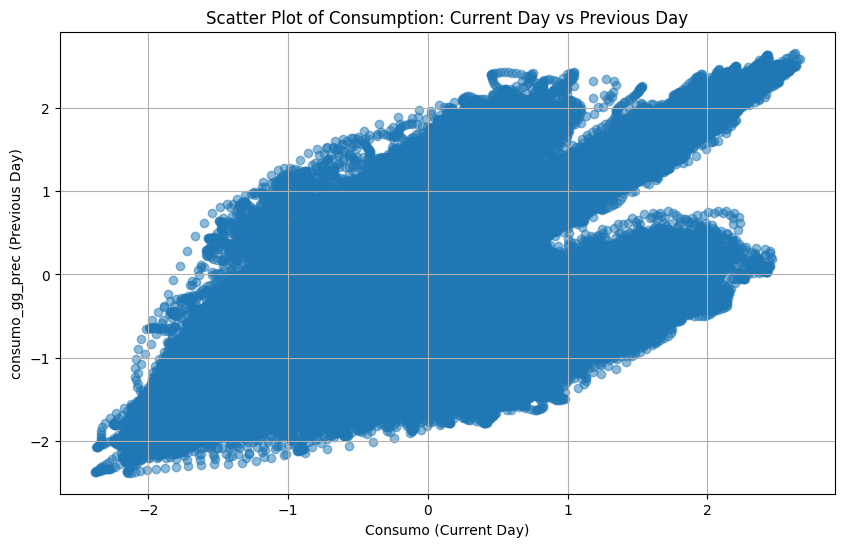

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_encoded_plt['Consumo'], df_encoded_plt['consumo_gg_prec'], alpha=0.5)
plt.xlabel('Consumo (Current Day)')
plt.ylabel('consumo_gg_prec (Previous Day)')
plt.title('Scatter Plot of Consumption: Current Day vs Previous Day')
plt.grid(True)
plt.show()

With a boxplot we visualize consumption on weekdays and working days.

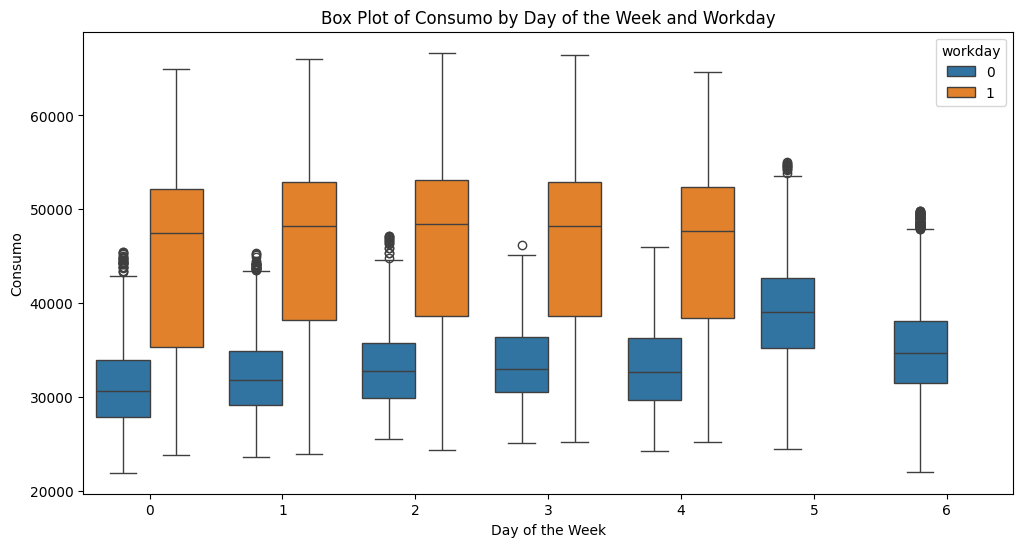

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='Consumo', hue='workday', data=df_train)
plt.xlabel('Day of the Week')
plt.ylabel('Consumo')
plt.title('Box Plot of Consumo by Day of the Week and Workday')
plt.show()

Let's see a scatter plot of the weather data with consumption.

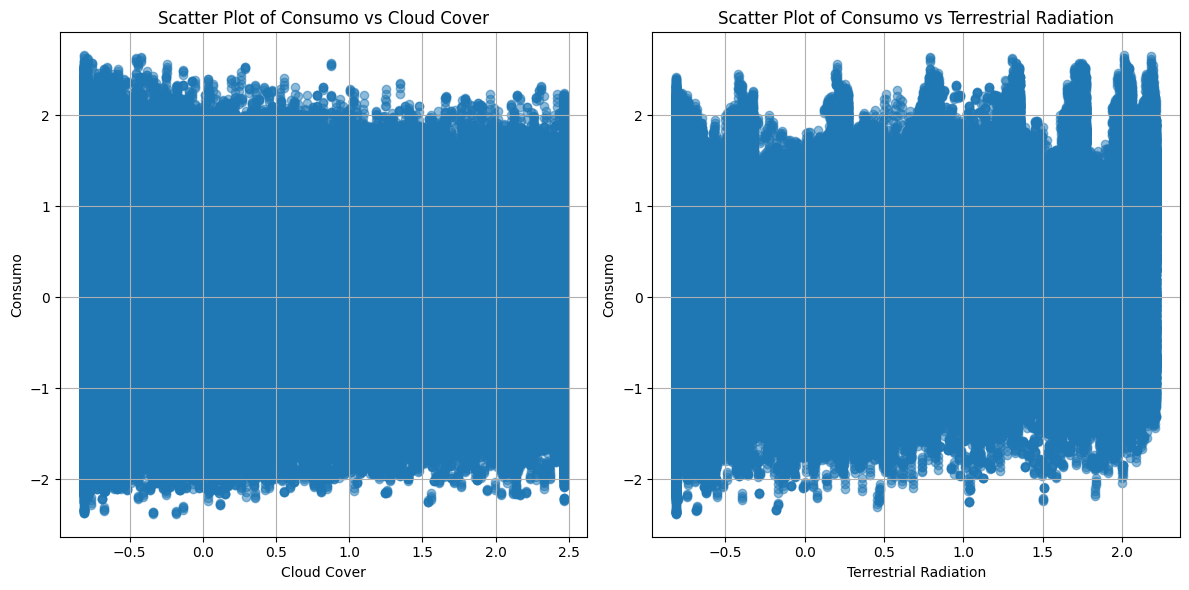

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for Consumo vs cloud_cover
axes[0].scatter(df_encoded_plt['cloud_cover'], df_encoded_plt['Consumo'], alpha=0.5)
axes[0].set_xlabel('Cloud Cover')
axes[0].set_ylabel('Consumo')
axes[0].set_title('Scatter Plot of Consumo vs Cloud Cover')
axes[0].grid(True)

# Scatter plot for Consumo vs terrestrial_radiation
axes[1].scatter(df_encoded_plt['terrestrial_radiation'], df_encoded_plt['Consumo'], alpha=0.5)
axes[1].set_xlabel('Terrestrial Radiation')
axes[1].set_ylabel('Consumo')
axes[1].set_title('Scatter Plot of Consumo vs Terrestrial Radiation')
axes[1].grid(True)

plt.tight_layout()
plt.show()

With a boxplot we see how the consumption data is distributed over the different seasons. We can see the presence of seasonality on the data series.

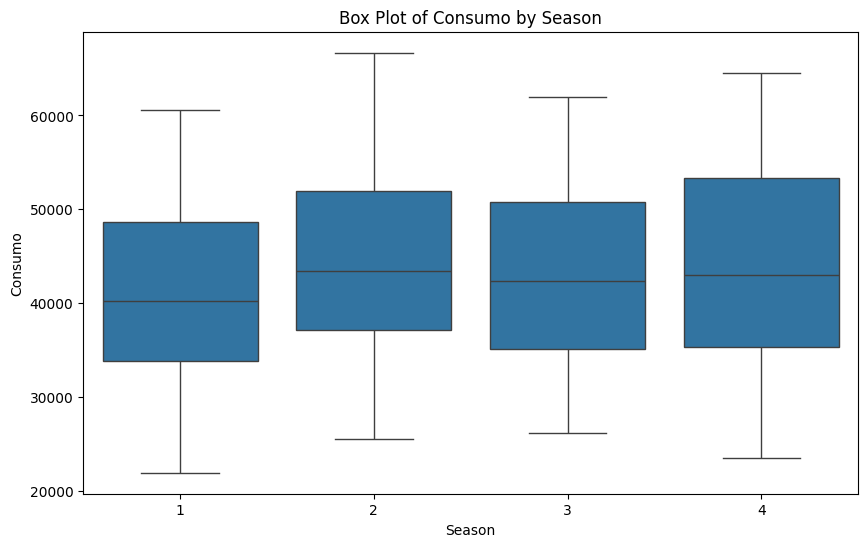

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='Consumo', data=df_train)
plt.xlabel('Season')
plt.ylabel('Consumo')
plt.title('Box Plot of Consumo by Season')
plt.show()

From this plot we can see how we have correctly identified the peaks.

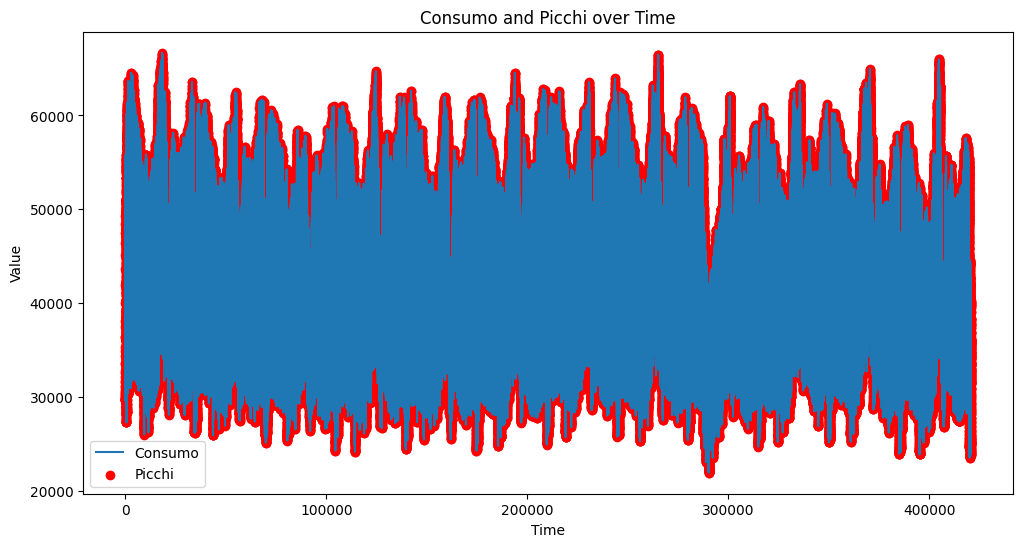

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_train['Consumo'], label='Consumo')
plt.scatter(df_train.index[df_train['rel_picchi']!=1e-12], df_train['Consumo'][df_train['rel_picchi']!=1e-12], color='red', label='Picchi')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Consumo and Picchi over Time')
plt.legend()
plt.show()

From the scaled data plot we have few outliers that we can consider acceptable.

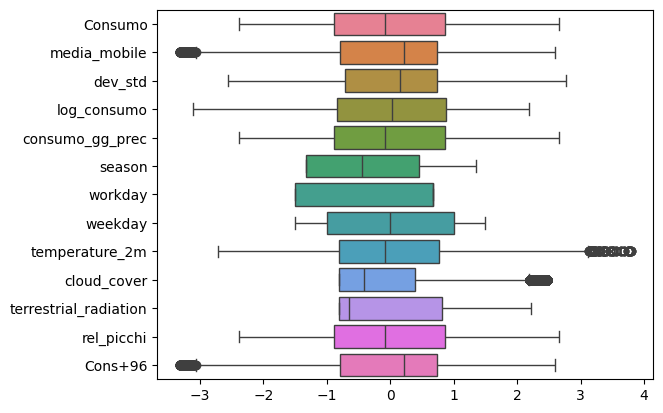

In [ ]:
sns.boxplot(data = df_encoded_plt, orient = "h")
plt.show()

In [ ]:
print(df_encoded_plt.shape)
df_encoded_plt.describe().T

(420576, 13)


,count,mean,std,min,25%,50%,75%,max
Consumo,420576.0,3.546496e-16,1.000001,-2.380461,-0.880083,-0.076702,0.868008,2.661325
media_mobile,420576.0,-1.346696e-15,1.000001,-3.317382,-0.787415,0.213926,0.733607,2.604073
dev_std,420576.0,-1.169100e-15,1.000001,-2.564389,-0.711000,0.153104,0.731114,2.777577
log_consumo,420576.0,7.637132e-15,1.000001,-3.103368,-0.847585,0.027930,0.885735,2.181410
consumo_gg_prec,420576.0,-3.984402e-16,1.000001,-2.381038,-0.880222,-0.076460,0.867943,2.661347
season,420576.0,-1.297499e-17,1.000001,-1.334759,-1.334759,-0.439402,0.455956,1.351313
workday,420576.0,-1.727295e-16,1.000001,-1.497592,-1.497592,0.667738,0.667738,0.667738
weekday,420576.0,-1.086655e-16,1.000001,-1.500557,-1.000485,-0.000342,0.999800,1.499872
temperature_2m,420576.0,8.325617e-17,1.000001,-2.718384,-0.803717,-0.079443,0.766739,3.792916
cloud_cover,420576.0,-2.513904e-17,1.000001,-0.814374,-0.804538,-0.420930,0.395465,2.464322


The correlation table shows us that the variables are highly correlated with each other.

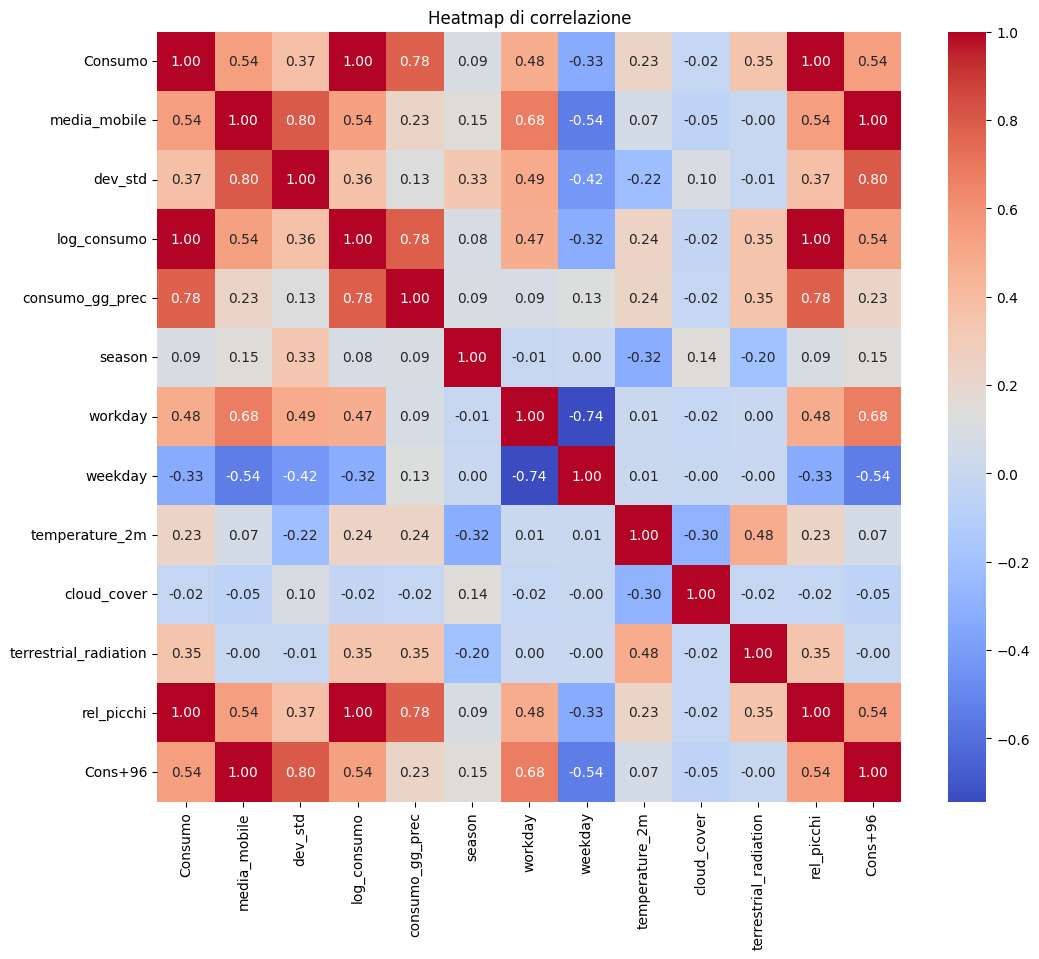

In [ ]:
# Calculate the correlation matrix
corr = df_encoded_plt.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of correlation')
plt.show()

Create a function for creating time series

In [ ]:
input_names = columns[:-1]
target = columns[-1]
print(f"The input columns are: {input_names.to_list()}. The target column is: {target}")

def create_time_series(df_val, df_loc, time_steps, input_names, target):
  X_list, y_list = [], []

  for i in range(len(df_val) - time_steps):
        X_list.append(df_val[i:i + time_steps, :][:, [df_loc.columns.get_loc(name) for name in input_names]])
        y_list.append(df_val[i + time_steps, df_loc.columns.get_loc(target)])

  return np.array(X_list), np.array(y_list)

The input columns are: ['Consumo', 'media_mobile', 'dev_std', 'log_consumo', 'consumo_gg_prec', 'season', 'workday', 'weekday', 'temperature_2m', 'cloud_cover', 'terrestrial_radiation', 'rel_picchi']. The target column is: Cons+96


In [ ]:
# create the series with a sequence of 96 (number of daily readings)
X_train, y_train = create_time_series(df_encoded, df_encoded_plt, seq_length, input_names, target)

# print the shapes of the series
print(X_train.shape,  y_train.shape)

(420480, 96, 12) (420480,)


Define the model as composed of three hybrid temporal blocks each formed by 2 conv1d layers and 3 bidirectional LSTM blocks. The temporal blocks are then concatenated and subjected to 2 dense layers. Before the output, a Dense attention layer with sigmoid activator is inserted.

In [ ]:
def temporal_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=24,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D(pool_size=2)(conv_1)
    average_1 = keras.layers.Dropout(0.5)(average_1)

    conv_2 = keras.layers.Conv1D(
        filters=48,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D(pool_size=2)(conv_2)
    average_2 = keras.layers.Dropout(0.5)(average_2)

    lstm_1 = keras.layers.Bidirectional(keras.layers.LSTM(units=32, return_sequences=True))(average_2)
    lstm_2 = keras.layers.Bidirectional(keras.layers.LSTM(units=32, return_sequences=True))(lstm_1)
    lstm_3 = keras.layers.Bidirectional(keras.layers.LSTM(units=16))(lstm_2)

    return lstm_3

def create_model(lr=1e-3):
    input_consumo = keras.Input(shape=(X_train.shape[1:]), name='Consumo')

    conv_1 = temporal_block(input_consumo, kernel_size_1=3, kernel_size_2=2)
    conv_2 = temporal_block(input_consumo, kernel_size_1=5, kernel_size_2=3)
    conv_3 = temporal_block(input_consumo, kernel_size_1=11, kernel_size_2=7)

    conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3])
    conc = keras.layers.Dropout(0.5)(conc)

    dense_1 = keras.layers.Dense(units=16, activation=keras.activations.swish)(conc)
    dense_2 = keras.layers.Dense(units=64, activation=keras.activations.swish)(dense_1)

    att = keras.layers.Dense(units=64, activation=keras.activations.sigmoid)(dense_2)

    dense_3 = keras.layers.Multiply()([dense_2, att])

    output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_3)

    model = keras.Model(inputs=input_consumo, outputs=output)

    model.name="EyNet"
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mean_absolute_error')
    return model


I fill the model with a very low learning rate 1e-5

Model: "EyNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Consumo (InputLayer)      │ (None, 96, 12)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 96, 24)         │            888 │ Consumo[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 96, 24)         │          1,464 │ Consumo[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 96, 24)         │          3,192 │ Consumo[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d         │ (None, 48, 24)         │              0 │ conv1d[0][0]           │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_2       │ (None, 48, 24)         │              0 │ conv1d_2[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_4       │ (None, 48, 24)         │              0 │ conv1d_4[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 48, 24)         │              0 │ average_pooling1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 48, 24)         │              0 │ average_pooling1d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 48, 24)         │              0 │ average_pooling1d_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 48, 48)         │          2,352 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 48, 48)         │          3,504 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 48, 48)         │          8,112 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_1       │ (None, 24, 48)         │              0 │ conv1d_1[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_3       │ (None, 24, 48)         │              0 │ conv1d_3[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_5       │ (None, 24, 48)         │              0 │ conv1d_5[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 194,185 (758.54 KB)

 Trainable params: 194,185 (758.54 KB)

 Non-trainable params: 0 (0.00 B)

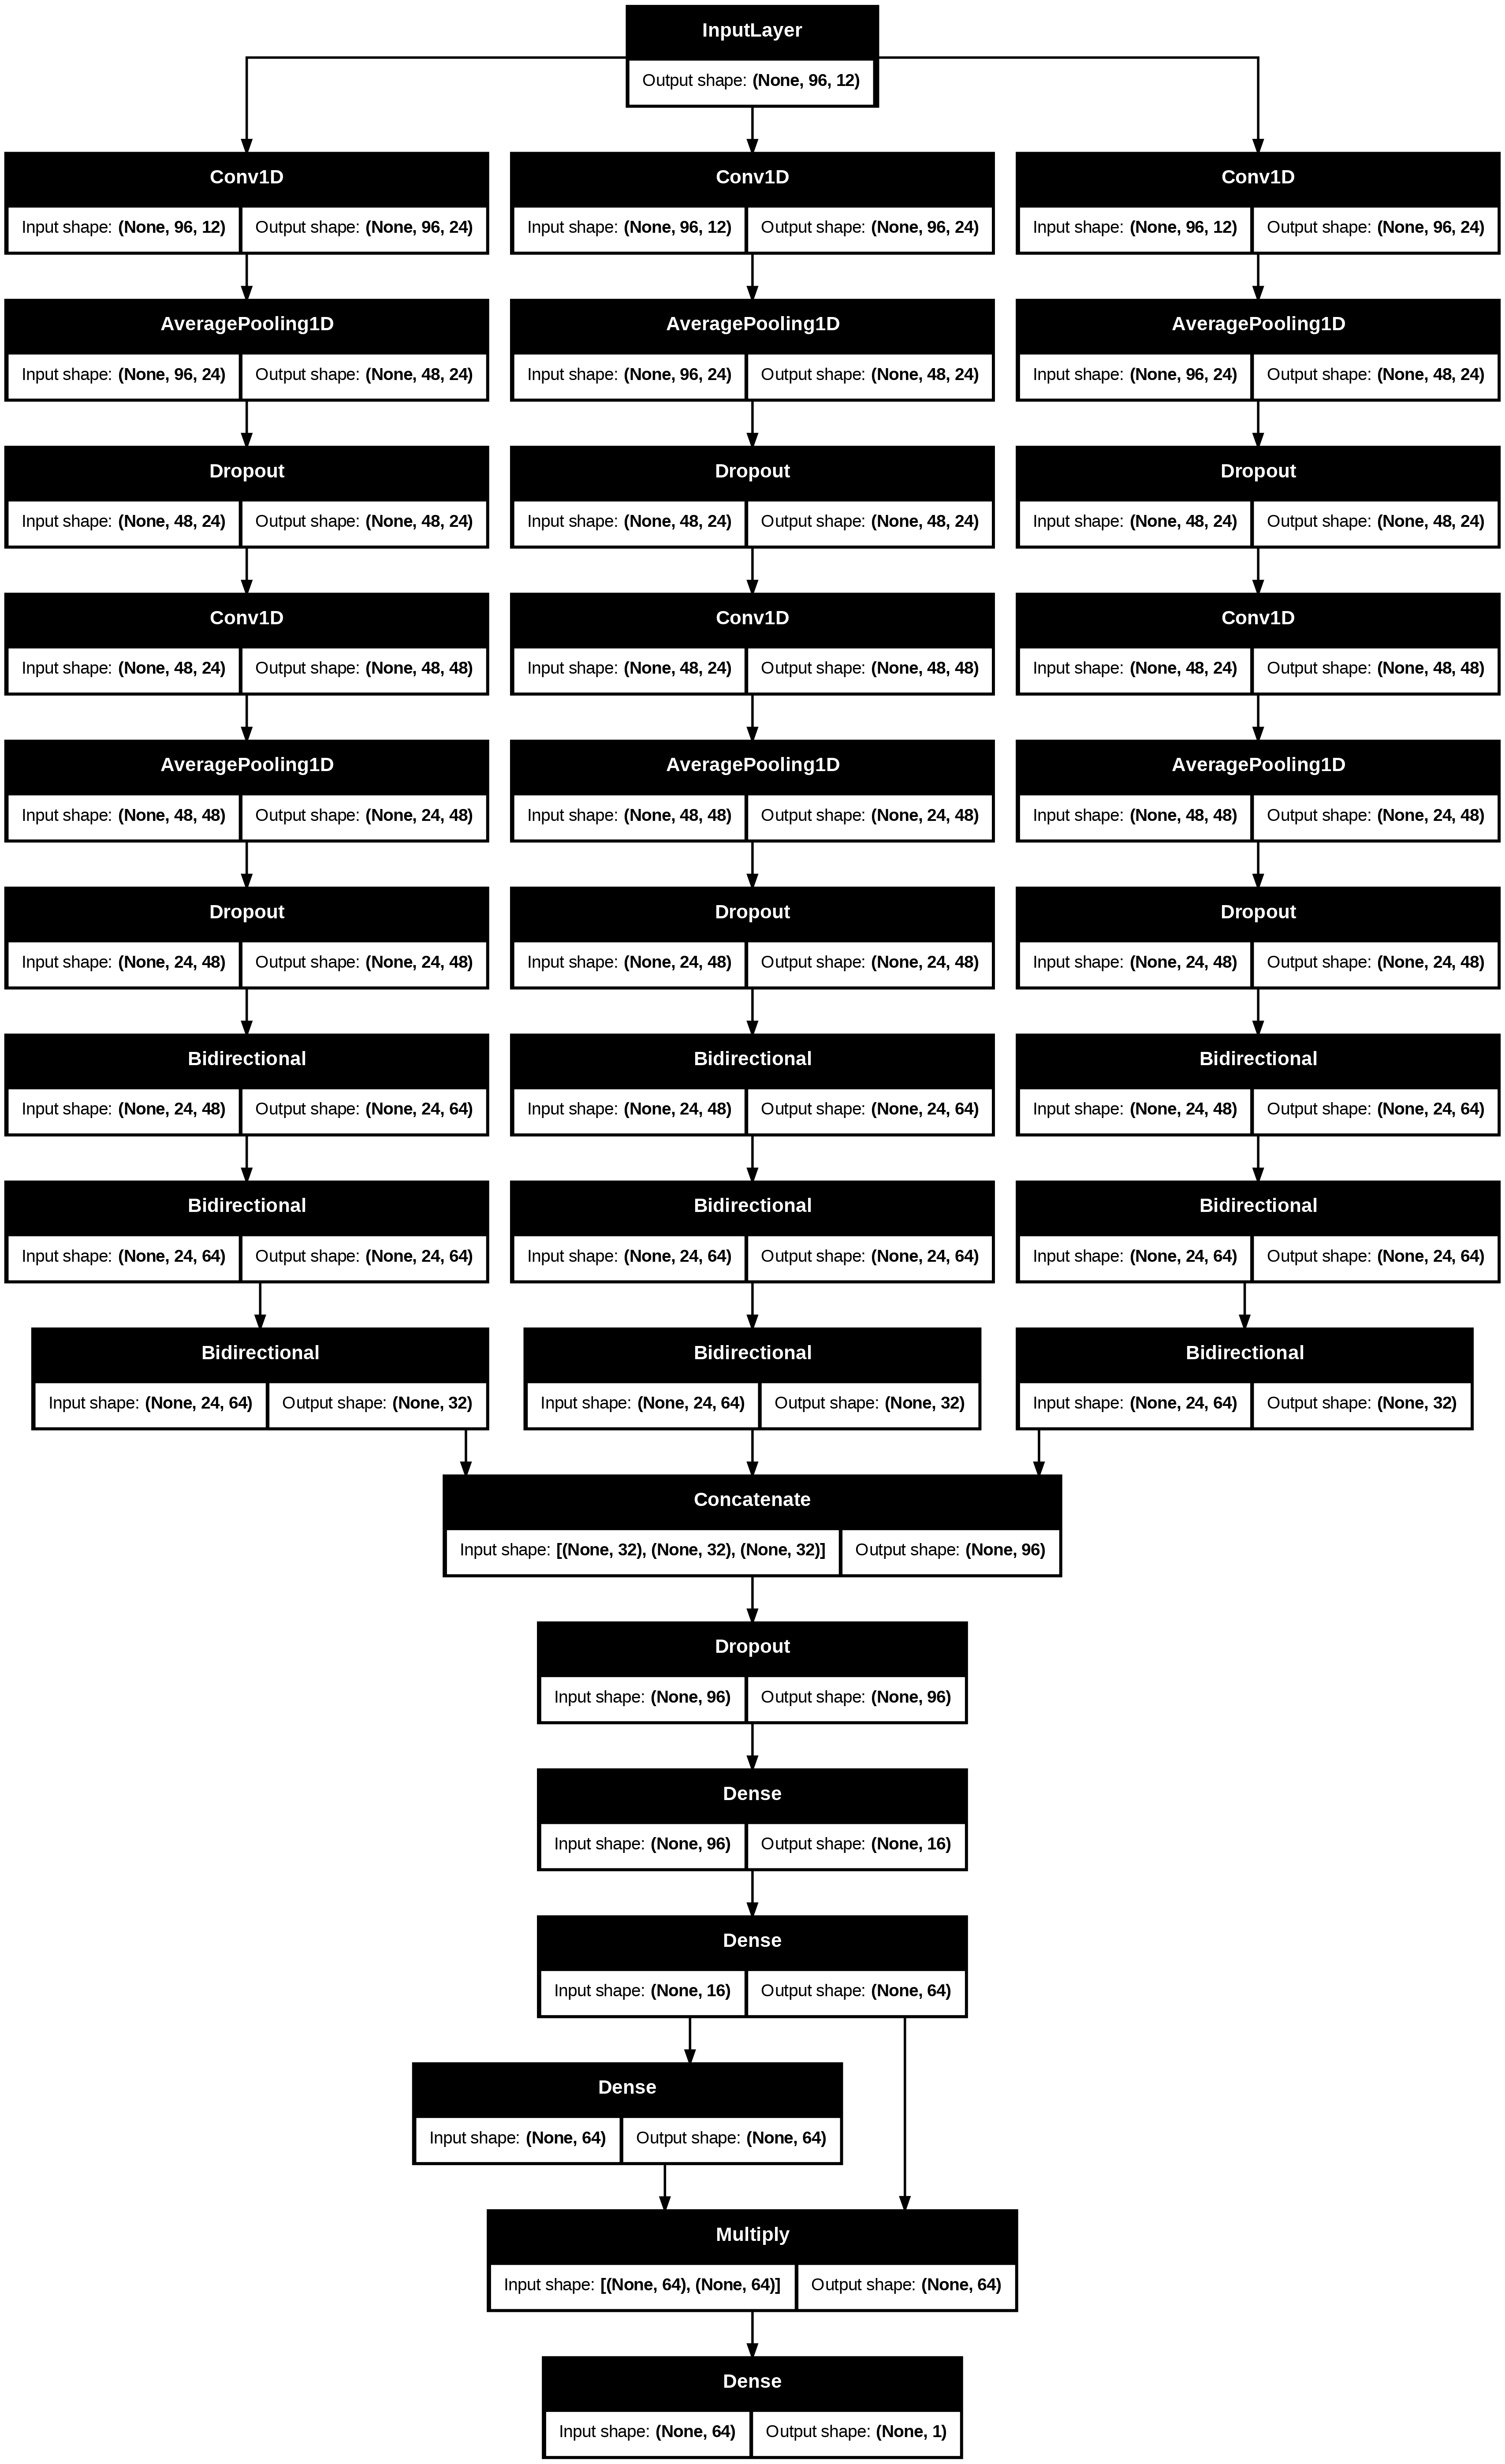

In [ ]:
model = create_model(lr=1e-5)
model.summary()
keras.utils.plot_model(model, "image/EyNet.png", show_shapes=True)

Verify the model by activating a training of 50 epochs and validation with 10% of the train data.

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=1024,
    validation_split=0.1
)

Epoch 1/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - loss: 0.8098 - val_loss: 0.6914
Epoch 2/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.6181 - val_loss: 0.4123
Epoch 3/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.3515 - val_loss: 0.2272
Epoch 4/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.2413 - val_loss: 0.1447
Epoch 5/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.1996 - val_loss: 0.1203
Epoch 6/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.1815 - val_loss: 0.1050
Epoch 7/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.1691 - val_loss: 0.0942
Epoch 8/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.1576 - val_loss: 0.0864
Epoch 9/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.1492 - val_loss: 0.0789
Epoch 10/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.1413 - val_loss: 0.0741
Epoch 11/50
370/370 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.1350 - val_loss: 0.0707
Epoch 12/50
370/370 ━━━━━━━━━━

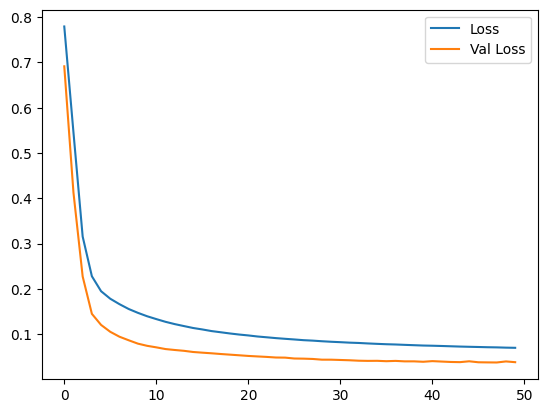

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(loc="upper right")
plt.show()

We see that the model is learning well. Let's continue training with another 150 epochs with all the training data.

In [ ]:
history = model.fit(
    X_train,
    y_train,
    initial_epoch=0,
    epochs=150,
    batch_size=1024
)

Epoch 1/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0661
Epoch 2/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0655
Epoch 3/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 0.0653
Epoch 4/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0651
Epoch 5/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0649
Epoch 6/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0645
Epoch 7/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0642
Epoch 8/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0639
Epoch 9/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 0.0635
Epoch 10/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0633
Epoch 11/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 0.0631
Epoch 12/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 0.0629
Epoch 13/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 0.0625
Epoch 14/150
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0620
Epoch 15/150
41

We save the model data and everything needed for prediction.

In [ ]:
# save last seq_length of df_train
dict_df_train = {
    "df_pad_test": df_pad_test,
    "columns": columns
}
with open('dati/df_trainEnergy', 'wb') as file_df:
    pickle.dump(dict_df_train, file_df)

# save model
model.save('dati/EnergyModel.keras')

# save weights model
model.save_weights('dati/Energy.weights.h5')

# save scaler
with open('dati/scalerEnergy', 'wb') as file_sc:
    pickle.dump(scaler, file_sc)

Restore previously saved model data.

In [ ]:
# add last seq_length of df_train
with open('dati/df_trainEnergy', 'rb') as file_df:
    dict_df_train = pickle.load(file_df)
    df_pad_test = dict_df_train["df_pad_test"]
    columns = dict_df_train["columns"]

# add model
model = keras.models.load_model('dati/EnergyModel.keras')

# add weights model
model.load_weights('dati/Energy.weights.h5')

# add scaler
with open('dati/scalerEnergy', 'rb') as file_sc:
    scaler = pickle.load(file_sc)


Open the test dataset and create the necessary features for model compatibility.

In [ ]:
# open the test dataset
df_test = pd.read_csv('dataset/test.csv')

# create the new column for the whole dataset
new_cons = []
for i in range(len(df_test) - seq_length):
  new_cons.append(df_test["Consumo"][i+1 : i+1+seq_length].sum())

new_cons.extend(np.zeros(shape=(seq_length,)))
df_test["Cons+96"] = new_cons

# we insert the last 96 rows of the train dataset for the feature gate
df_test_new = pd.concat([df_pad_test[-(seq_length*2):], df_test])

# load the features, typetrain=False will activate knninput
df_test_ft = add_features(df_test_new, seq_length, typetrain=False)

# remove the lines we don't need
df_test_pred = df_test_ft[seq_length:]

print(df_test_pred.shape)
df_test_pred

(2973, 15)


,Unnamed: 0,Datetime,Consumo,media_mobile,dev_std,log_consumo,consumo_gg_prec,season,workday,weekday,temperature_2m,cloud_cover,terrestrial_radiation,rel_picchi,Cons+96
96,420669.0,2023-12-31 00:00:00,27755.022166,30746.319500,4.291500e+03,10.231172,28550.658602,4,0,6,11.455,88.200005,0.0,2775.502217,2.951647e+06
97,420670.0,2023-12-31 00:15:00,27278.620314,30748.224424,4.289985e+03,10.213859,28024.321693,4,0,6,11.455,88.200005,0.0,2727.862031,2.951830e+06
98,420671.0,2023-12-31 00:30:00,26769.214242,30750.896684,4.287560e+03,10.195008,27459.806785,4,0,6,11.455,88.200005,0.0,2676.921424,2.952086e+06
99,420672.0,2023-12-31 00:45:00,26276.255344,30754.209633,4.284187e+03,10.176421,26921.763451,4,0,6,11.455,88.200005,0.0,2627.625534,2.952404e+06
100,420673.0,2023-12-31 01:00:00,25849.244074,30758.027747,4.279931e+03,10.160037,26474.908993,4,0,6,12.705,88.200005,0.0,2584.924407,2.952771e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,423637.0,2024-01-30 22:00:00,44016.278160,41809.592795,2.643851e+02,10.692315,43990.222276,4,1,1,6.355,0.000000,0.0,4401.627816,0.000000e+00
3065,423638.0,2024-01-30 22:15:00,42837.682487,41799.137777,2.422175e+02,10.665173,42831.574449,4,1,1,6.355,0.000000,0.0,4283.768249,0.000000e+00
3066,423639.0,2024-01-30 22:30:00,41722.796684,41800.296152,2.421145e+02,10.638803,41715.777929,4,1,1,6.355,0.000000,0.0,4172.279668,0.000000e+00
3067,423640.0,2024-01-30 22:45:00,40686.934457,41812.244759,2.131642e+02,10.613662,40640.635430,4,1,1,6.355,0.000000,0.0,4068.693446,0.000000e+00


Make predictions on test data.

In [ ]:
df_test_scaled = scaler.transform(df_test_pred[columns])
df_test_enc = pd.DataFrame(df_test_scaled, columns=columns)

X_test, y_test = create_time_series(df_test_scaled, df_test_enc, seq_length, input_names, target)

y_pred = model.predict(X_test, batch_size=512)

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 914ms/step


Since we do not have data from the last 96 observations, we only check data that are comparable.

In [ ]:
y_test_mae = y_test[:-seq_length]
y_pred_mae = y_pred[:-seq_length].flatten()

print(f"The MAE is {np.sum(np.abs(y_test_mae - y_pred_mae)) / len(y_test_mae)}")

The MAE is 0.03424913362990872


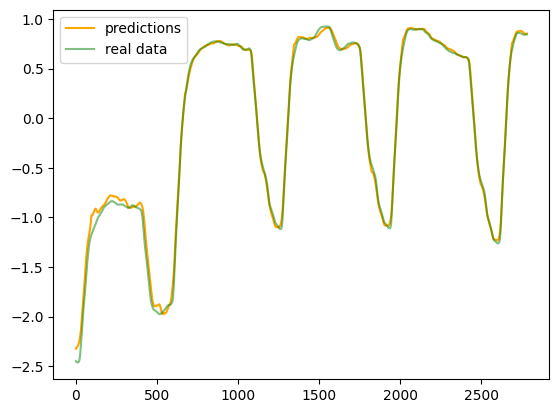

In [ ]:
plt.plot(y_pred[:-seq_length], color='orange', label='predictions')
plt.plot(y_test[:-seq_length], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [ ]:
# prediction extraction
trainPredict = np.zeros(shape=(len(y_pred), df_test_scaled.shape[1]) )
trainPredict[:,-1] = y_pred[:,0]
y_pred_denorm = scaler.inverse_transform(trainPredict)[:,-1]

In [ ]:
# append predictions to dataset
df_test["Cons+96"] = y_pred_denorm
df_test

,Unnamed: 0,Datetime,Consumo,Cons+96
0,420765,2024-01-01 00:00:00,27852.916774,2.930604e+06
1,420766,2024-01-01 00:15:00,27461.493056,2.933124e+06
2,420767,2024-01-01 00:30:00,27025.751227,2.934486e+06
3,420768,2024-01-01 00:45:00,26594.298451,2.935594e+06
4,420769,2024-01-01 01:00:00,26215.782975,2.936114e+06
...,...,...,...,...
2872,423637,2024-01-30 22:00:00,44016.278160,4.149045e+06
2873,423638,2024-01-30 22:15:00,42837.682487,4.139924e+06
2874,423639,2024-01-30 22:30:00,41722.796684,4.131837e+06
2875,423640,2024-01-30 22:45:00,40686.934457,4.124114e+06


In [ ]:
# creation of the CSV file to submit for
# participation in the Data Challenge

df_test.to_csv("dataset/submission.csv")